In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

sns.set_context("talk")

sns.set_theme(style="white")

# load irmsd scores
def get_irmsd(score_files): 
    def parse_score(score_file):
        df = pd.read_csv(score_file, sep = ":", skiprows=1, header = None )
        df.columns = ["metric", "val"]
        df.metric = df.metric.str.split("\s+", expand = True)[2]
        df.val = df.val.str.split("\s+",expand = True)[1]
        df.index = df.metric
        df = df.drop("metric", axis = 1)
        df = df.T.reset_index().drop("index", axis = 1)
        name = os.path.basename(score_file).replace(".total_irmsd", "")
        df["name"] = name
        db = str(score_file.split("/")[-5]) +"-"+ str(score_file.split("/")[-4])
        df["db"] = db
        return(df)
    scores = pd.concat(list(map(parse_score, score_files)))
    return(scores)


# get normal scores
def get_refs(score_files): 
    def parse_score(score_file):
        db = str(score_file.split("/")[-6]) +"-"+ str(score_file.split("/")[-5])
        df = pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1)
        df["db"] = db
        return(df)

    scores = pd.concat(list(map(parse_score, score_files)))
    scores = scores.iloc[:,0:5]
    scores.columns = ['name', 'sp', 'tc', 'column', 'db']
    return(scores)


def get_scores(pattern, ref = True, irmsd = True): 
    if ref: 
        pattern = "*-ref"+pattern
    else:
        pattern = "*[!ref]"+pattern 
    df2 = get_refs((glob.glob(os.path.join(data_dir, "evaluation/score/*/"+pattern))))
        
    if irmsd: 
        df1 = get_irmsd((glob.glob(os.path.join(data_dir, "evaluation/irmsd/"+pattern+"irmsd"))))
        df = df1.merge(df2, on = ["name", "db"])
    else: 
        df = df2
    return df


def plot_scatter_perc(df1,df2,xlabel,ylabel,
                      palette = sns.dark_palette("#3399FF", reverse = True, as_cmap=True),
                      log = True, 
                      title = "regressive on homfam", hue_var = "sim", metric = "tc", size_fig = 1): 
    f, ax = plt.subplots(figsize=(8*size_fig,6.4*size_fig ))
    
    # Prep df 
    df = df1.merge(df2, on = ["family", hue_var])
    
    df["sim"] = 1
    hue = df[hue_var]
    hue = 1
    # colorbar 
    norm = mpl.colors.Normalize( vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    
    # Color bar 
    cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())
    cbar.ax.set_yticklabels(["0", "50", "100"]) 
    cbar.ax.set_ylabel('avg % similarity', rotation=270, labelpad = 20, fontsize = "small")
    
    metric_x = metric+"_x"
    metric_y = metric+"_y"
    # Plot 
    ax = sns.scatterplot(data = df, x = metric_x,
                    y = metric_y,
                    hue = hue_var,
                    s = 100,
                    palette = palette)

    # % above the line
    perc_y_better_than_x = (len(list(filter(lambda ele: ele == True, list(df[metric_x] <= df[metric_y])))) / len(list(df[metric_x]  >= df[metric_y] ))) * 100
    
    # Diagonal line
    ax.axline((1, 1), slope=1, ls="--", c=".2", lw = 0.8)
    
    if(metric != "NiRMSD"): 
        ax.set(xlim = (0,100), ylim = (0,100))
    ax.get_legend().remove()
    
    # Axis labels
    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title = title + "\n metric: "+metric+"\n (n = "+str(len(df[metric_x] ))+") \n\n % y >= x  "+str(round(perc_y_better_than_x,1))+" \n")

    
    
def plot_scatter_perc(df1,df2,xlabel,ylabel,
                      palette = sns.dark_palette("#3399FF", reverse = True, as_cmap=True),
                      log = True, 
                      title = "regressive on homfam", hue_var = "sim", metric = "tc", size_fig = 1): 
    f, ax = plt.subplots(figsize=(7*size_fig,6.4*size_fig ))
    
    # Prep df 
    df = df1.merge(df2, on = ["family", hue_var])
    
    hue = df[hue_var]
    # colorbar 
    norm = mpl.colors.Normalize( vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    
    # Color bar 
    cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())
    cbar.ax.set_yticklabels(["0", "50", "100"]) 
    cbar.ax.set_ylabel('avg % similarity', rotation=270, labelpad = 20, fontsize = "small")

    metric_x = metric+"_x"
    metric_y = metric+"_y"
    # Plot 
    ax = sns.scatterplot(data = df, x = metric_x,
                    y = metric_y, s = 80, hue = hue_var,
                    palette = palette)

    # % above the line
    perc_y_better_than_x = (len(list(filter(lambda ele: ele == True, list(df[metric_x] <= df[metric_y])))) / len(list(df[metric_x]  >= df[metric_y] ))) * 100
    
    # Diagonal line
    ax.axline((1, 1), slope=1, ls="--", c=".2", lw = 0.8)
    ax.get_legend().remove()
    if(metric not in ["NiRMSD","iRMSD"]): 
        ax.set(xlim = (0,100), ylim = (0,100))
    else: 
        ax.set(xlim = (3,0), ylim = (3,0))

    # Axis labels
    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title = title + "\n metric: "+metric+"\n (n = "+str(len(df[metric_x] ))+") \n\n % y >= x  "+str(round(perc_y_better_than_x,1))+" \n")

def plot_scatter_perc_bin(df1,df2,xlabel,ylabel,
                      palette = sns.dark_palette("#3399FF", reverse = True, as_cmap=True),
                      log = True, 
                      title = "regressive on homfam", hue_var = "domain", metric = "tc", size_fig = 1): 
    f, ax = plt.subplots(figsize=(7*size_fig,6.4*size_fig ))
    
    # Prep df 
    df = df1.merge(df2, on = ["family", hue_var])
    
    hue = df[hue_var]


    metric_x = metric+"_x"
    metric_y = metric+"_y"
    # Plot 
    ax = sns.scatterplot(data = df, x = metric_x,
                    y = metric_y, s = 80, hue = hue_var)

    # % above the line
    perc_y_better_than_x = (len(list(filter(lambda ele: ele == True, list(df[metric_x] <= df[metric_y])))) / len(list(df[metric_x]  >= df[metric_y] ))) * 100
    
    # Diagonal line
    ax.axline((1, 1), slope=1, ls="--", c=".2", lw = 0.8)
    if(metric not in ["NiRMSD","iRMSD"]): 
        ax.set(xlim = (0,100), ylim = (0,100))
    else: 
        ax.set(xlim = (0,3), ylim = (0,3))

    # Axis labels
    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title = title + "\n metric: "+metric+"\n (n = "+str(len(df[metric_x] ))+") \n\n % y >= x  "+str(round(perc_y_better_than_x,1))+" \n")

def get_summary_lib(library):
    file1 = open(library, 'r')
    Lines = file1.readlines()


    count = 0
    header_finished = False

    seq_indexes = pd.DataFrame()
    residues = pd.DataFrame()

    # Strips the newline character
    for line in Lines:
        if line.startswith("!"):
            count += 1
            continue
        if count == 0:
            count += 1
            continue
        elif count == 1: 
            nseq = int(line)
            count += 1
            continue
        elif count == nseq+2: 
            header_finished = True

        if not header_finished: 
            count += 1
            # ----- PARSE INDEXES SEQUENCES 
            seq_id = line.split()[0]
            seq = line.split()[2]
            idx_seq = count-2
            entry = pd.DataFrame({"index":[idx_seq], "seq_name":[seq_id]})
            seq_indexes = pd.concat([seq_indexes, entry])
        else:
            # ------- PARSE RESIDUES 
            if line.startswith("#"): 
                seq1 = line.replace("#","").split(" ")[0]
                seq2 = line.replace("#","").split(" ")[1]
            else:
                res1 = line.split()[0]
                res2 = line.split()[1]
                value = line.split()[2]
                res_entry = pd.DataFrame({"seq1":[seq1], "seq2":[seq2], "res1":[res1], "res2":[res2], "value":[value]})
                residues = pd.concat([residues,res_entry])
    residues["id"] = residues.seq1+"-"+residues.seq2+"-"+residues.res1+"-"+residues.res2
    return(residues)

In [3]:
families_homfam = pd.read_csv('/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/refs/02_summary_homfam_refs.csv')
families_benchfam = pd.read_csv('/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/refs/02_summary_benchfam_refs.csv')
fams_all_str = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/refs/homfam/fams_with_structure.csv")
fams_all_str = fams_all_str.family
# Add TCS to benchfam 
tcs = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/refs/benchfam/tcs.csv")
#families_benchfam = families_benchfam.merge(tcs, on = "family")
#families_benchfam.tcs = families_benchfam.tcs /100

In [4]:
def get_scores_summary(pattern = "*", irmsd = True, cat = ["family","library_method", "tree_method"]):
    scores = get_scores(pattern, irmsd = irmsd)
    scores[cat] = scores.name.str.split(".", expand = True)
    scores = scores.merge(families, on = ["family"])
    if irmsd:
        scores["NiRMSD"] = scores["NiRMSD"].astype(float)
        scores["iRMSD"] = scores["iRMSD"].astype(float)
        scores["APDB"] = scores["APDB"].astype(float)
        scores["EVALUATED"] = scores["EVALUATED"].astype(float)
    return(scores)

# HOMFAM

In [9]:
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam_ref/AF2_PRED/*"
families = families_homfam
foldseek_sequence_scores = get_scores_summary("*fs_sequence*", irmsd= True)
proba_scores = get_scores_summary("*proba_only*", irmsd= True)
foldseek_scores = get_scores_summary("*fs_only*", irmsd= True)
tm_scores = get_scores_summary("*3D*", cat = ["family", "align_method" ,"library_method", "tree_method"], irmsd = True)
homfam_af2_scores = pd.concat([foldseek_sequence_scores,proba_scores,foldseek_scores,tm_scores])
#homfam_af2_scores.to_csv("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam_ref/01_AF2_SCORES_irsmd.csv", index = False)

In [ ]:
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam_ref/PDB/B/B/"
families = families_homfam
foldseek_sequence_scores = get_scores_summary("*fs_sequence*", irmsd= True)
proba_scores = get_scores_summary("*proba_only*", irmsd= True)
foldseek_scores = get_scores_summary("*fs_only*", irmsd= True)
tm_scores = get_scores_summary("*3D*", cat = ["family", "align_method" ,"library_method", "tree_method"], irmsd = True)
homfam_af2_scores = pd.concat([foldseek_sequence_scores,proba_scores,foldseek_scores,tm_scores])
#homfam_af2_scores.to_csv("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam_ref/01_AF2_SCORES_irsmd.csv", index = False)

In [10]:
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam_ref/UniProtKB/*"
families = families_homfam
foldseek_sequence_scores = get_scores_summary("*fs_sequence*", irmsd= True)
proba_scores = get_scores_summary("*proba_only*", irmsd= True)
foldseek_scores = get_scores_summary("*fs_only*", irmsd= True)
tm_scores = get_scores_summary("*3D*", cat = ["family", "align_method" ,"library_method", "tree_method"], irmsd = True)
homfam_uniprot_scores = pd.concat([foldseek_sequence_scores,proba_scores,foldseek_scores,tm_scores])
homfam_uniprot_scores.to_csv("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam_ref/01_UNIPROT_SCORES_irsmd.csv", index = False)

In [5]:
homfam_af2_scores  = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam_ref/01_AF2_SCORES_irsmd.csv")
homfam_uniprot_scores  = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam_ref/01_UNIPROT_SCORES_irsmd.csv")
homfam_scores = pd.concat([homfam_af2_scores, homfam_uniprot_scores])


In [4]:
# Load data
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam_ref/*/*"
families = families_homfam

foldseek_sequence_scores = get_scores_summary("*fs_sequence*", irmsd= True)
proba_scores = get_scores_summary("*proba_only*", irmsd= True)
foldseek_scores = get_scores_summary("*fs_only*", irmsd= True)
tm_scores = get_scores_summary("*3D*", cat = ["family", "align_method" ,"library_method", "tree_method"])

homfam_scores = pd.concat([foldseek_sequence_scores,proba_scores,foldseek_scores,tm_scores])

In [12]:
homfam_scores.db.value_counts()

AF2_PRED-1.0                 372
UniProtKB-id_0.95_cov_1.0     37
Name: db, dtype: int64

## 1. How does the source of the structures affect 3di/consistency performance? 

In [8]:
#foldseek_sequence_scores[(foldseek_sequence_scores.db == "PDB")& (foldseek_sequence_scores.sp < 50)]

In [25]:
fams = ('Acetyltransf,DEATH,GEL,HMG_box,LIM,PDZ,annexin,az,biotin_lipoyl,cyt3,flav,gluts,hip,hla,hom,hpr,icd,il8,int,phoslip,profilin,ricin,rvp,scorptoxin,seatoxin,slectin,sodfe,tim,tms')
fams_clean_and_complete = fams.split(",")

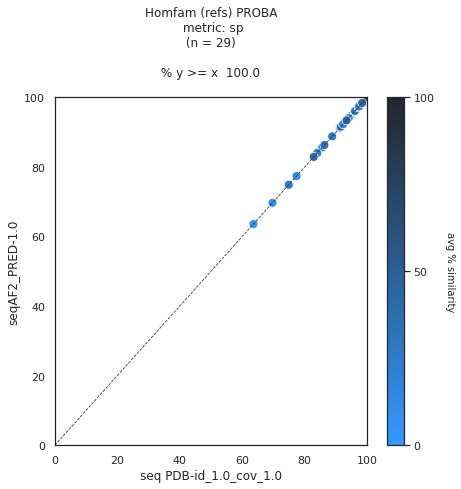

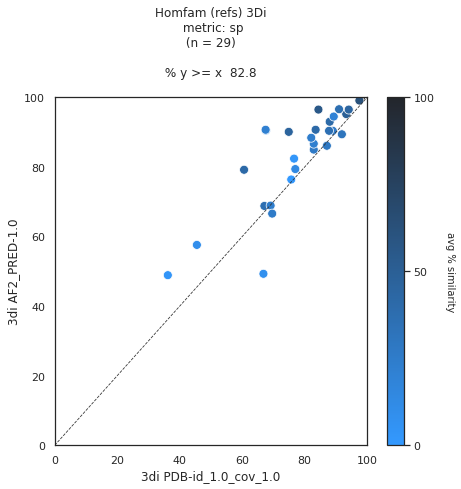

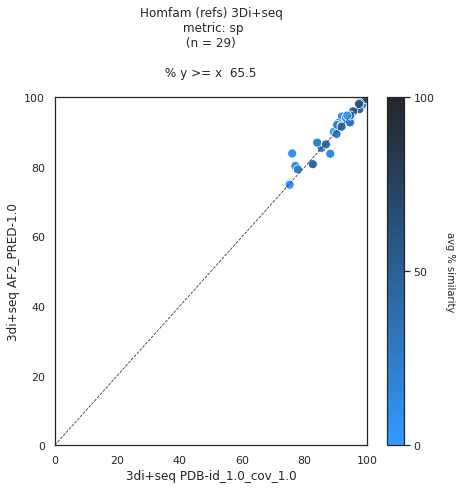

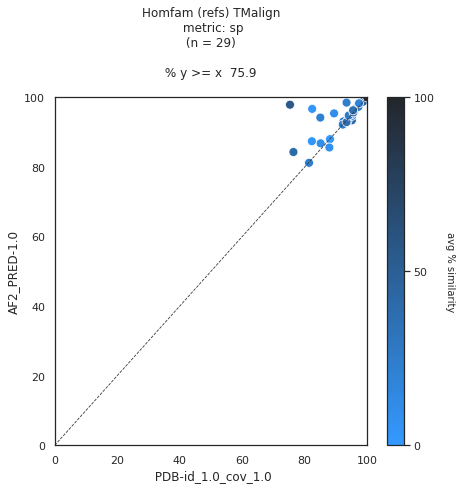

In [65]:
#met1  = "UniProtKB-id_0.9_cov_1.0"
met1 = "PDB-id_1.0_cov_1.0"
met2 = "AF2_PRED-1.0"

scores = homfam_scores
scores["family"] = scores.family.str.replace("-ref", "")
scores = scores[scores.family.isin(fams_clean_and_complete)]

proba_scores = scores[scores.library_method == "proba_only"]
foldseek_scores = scores[scores.library_method == "fs_only"]
foldseek_sequence_scores = scores[scores.library_method == "fs_sequence"]
tm_scores = scores[scores.library_method == "3DCOFFEE"]

metric = "sp"

plot_scatter_perc(proba_scores[proba_scores.db == met1],proba_scores[proba_scores.db == met2], "seq "+met1, "seq"+met2,metric = metric, title = "Homfam (refs) PROBA")
plot_scatter_perc(foldseek_scores[foldseek_scores.db == met1],foldseek_scores[foldseek_scores.db == met2], "3di "+met1, "3di "+met2,metric = metric, title = "Homfam (refs) 3Di")
plot_scatter_perc(foldseek_sequence_scores[foldseek_sequence_scores.db == met1],foldseek_sequence_scores[foldseek_sequence_scores.db == met2], "3di+seq "+met1, "3di+seq "+met2,metric = metric, title = "Homfam (refs) 3Di+seq")
plot_scatter_perc(tm_scores[tm_scores.db == met1],tm_scores[tm_scores.db == met2], " "+met1, ""+met2,metric = metric, title = "Homfam (refs) TMalign")


In [ ]:
# Test uniprot

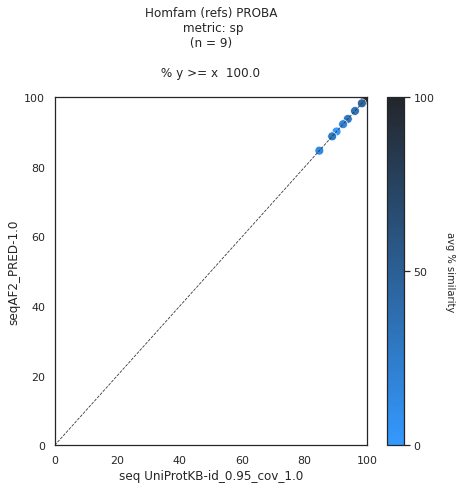

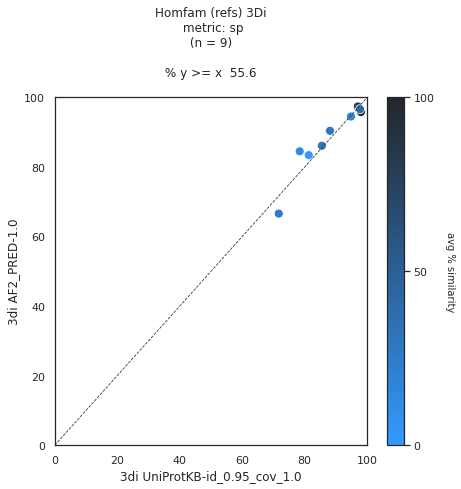

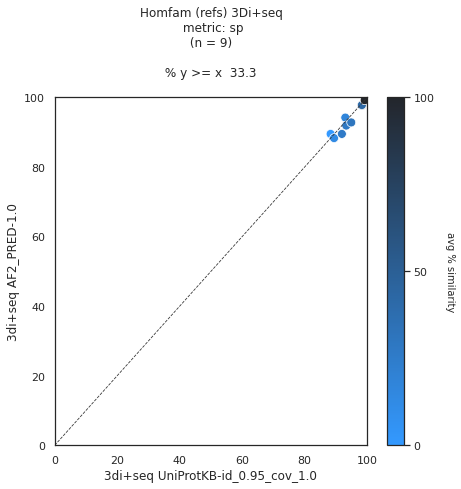

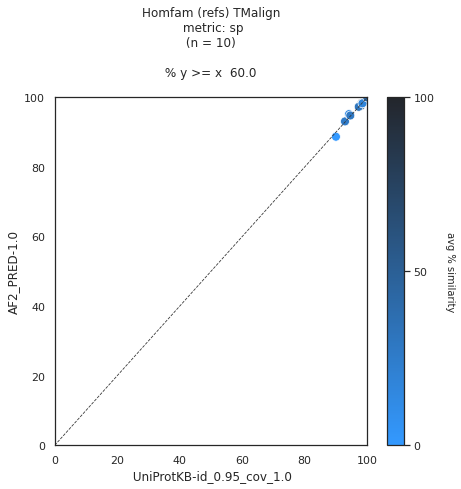

In [13]:
fams = 'TNF-ref,adh-ref,blm-ref,flav-ref,hpr-ref,mmp-ref,msb-ref,profilin-ref,ricin-ref,slectin-ref'
fams_clean_and_complete = fams.split(",")

met1  = "UniProtKB-id_0.95_cov_1.0"
met2 = "AF2_PRED-1.0"

scores = homfam_scores
#scores = scores[scores.family.isin(fams_clean_and_complete)]

proba_scores = scores[scores.library_method == "proba_only"]
foldseek_scores = scores[scores.library_method == "fs_only"]
foldseek_sequence_scores = scores[scores.library_method == "fs_sequence"]
tm_scores = scores[scores.library_method == "3DCOFFEE"]

metric = "sp"

plot_scatter_perc(proba_scores[proba_scores.db == met1],proba_scores[proba_scores.db == met2], "seq "+met1, "seq"+met2,metric = metric, title = "Homfam (refs) PROBA")
plot_scatter_perc(foldseek_scores[foldseek_scores.db == met1],foldseek_scores[foldseek_scores.db == met2], "3di "+met1, "3di "+met2,metric = metric, title = "Homfam (refs) 3Di")
plot_scatter_perc(foldseek_sequence_scores[foldseek_sequence_scores.db == met1],foldseek_sequence_scores[foldseek_sequence_scores.db == met2], "3di+seq "+met1, "3di+seq "+met2,metric = metric, title = "Homfam (refs) 3Di+seq")
plot_scatter_perc(tm_scores[tm_scores.db == met1],tm_scores[tm_scores.db == met2], " "+met1, ""+met2,metric = metric, title = "Homfam (refs) TMalign")


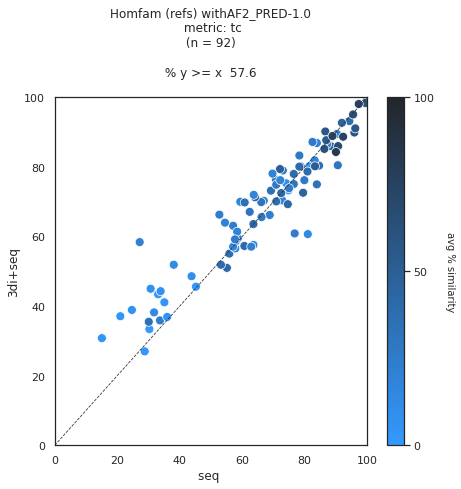

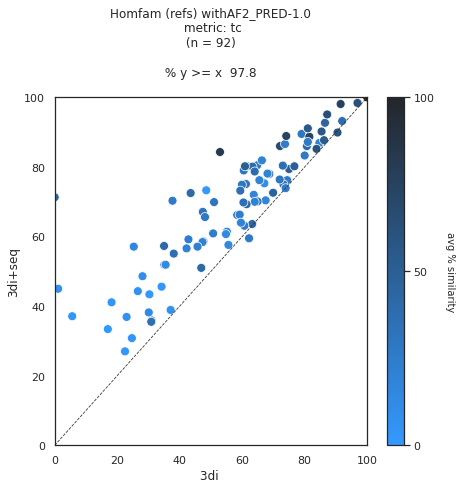

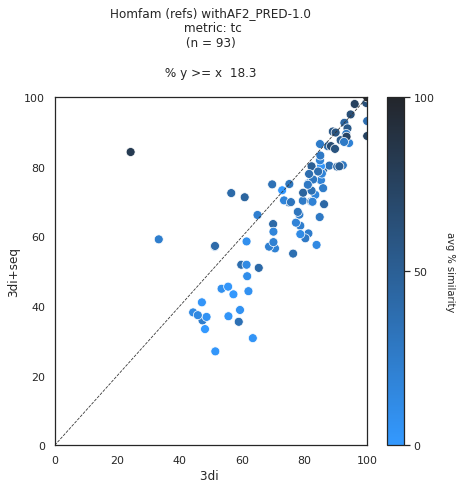

In [28]:
met2 = "AF2_PRED-1.0"
met = met2
metric = "tc"
plot_scatter_perc(proba_scores[proba_scores.db == met],foldseek_sequence_scores[foldseek_sequence_scores.db == met], "seq ", "3di+seq",metric = metric, title = "Homfam (refs) with"+met)
plot_scatter_perc(foldseek_scores[foldseek_scores.db == met],foldseek_sequence_scores[foldseek_sequence_scores.db == met], "3di ", "3di+seq",metric = metric, title = "Homfam (refs) with"+met)
plot_scatter_perc(tm_scores[tm_scores.db == met],foldseek_sequence_scores[foldseek_sequence_scores.db == met], "3di ", "3di+seq",metric = metric, title = "Homfam (refs) with"+met)


In [61]:
fam = "Acetyltransf"
homfam_scores[homfam_scores.family == fam]

,EVALUATED,APDB,iRMSD,NiRMSD,name,db,sp,tc,column,family,library_method,tree_method,benchmarking_dataset,sim,mean,median,max,n_sequences,align_method
52,71.04,65.67,0.94,1.32,Acetyltransf-ref.fs_sequence.MBED,PDB-id_1.0_cov_1.0,76.0,34.4,42.8,Acetyltransf,fs_sequence,MBED,homfam,29.07,161.5,163.0,181,6,NaN
53,76.57,73.14,0.82,1.07,Acetyltransf-ref.fs_sequence.MBED,AF2_PRED-1.0,83.9,45.0,56.0,Acetyltransf,fs_sequence,MBED,homfam,29.07,161.5,163.0,181,6,NaN
38,64.22,70.68,0.86,1.33,Acetyltransf-ref.proba_only.MBED,PDB-id_1.0_cov_1.0,69.7,30.7,38.9,Acetyltransf,proba_only,MBED,homfam,29.07,161.5,163.0,181,6,NaN
39,65.65,74.37,0.79,1.21,Acetyltransf-ref.proba_only.MBED,AF2_PRED-1.0,69.7,30.7,38.9,Acetyltransf,proba_only,MBED,homfam,29.07,161.5,163.0,181,6,NaN
4,64.13,68.54,0.92,1.44,Acetyltransf-ref.fs_only.MBED,PDB-id_1.0_cov_1.0,66.8,29.1,32.1,Acetyltransf,fs_only,MBED,homfam,29.07,161.5,163.0,181,6,NaN
5,54.39,65.79,1.00,1.83,Acetyltransf-ref.fs_only.MBED,AF2_PRED-1.0,49.3,1.1,0.3,Acetyltransf,fs_only,MBED,homfam,29.07,161.5,163.0,181,6,NaN
50,79.96,71.89,0.82,1.02,Acetyltransf-ref.progressive.3DCOFFEE.MBED,PDB-id_1.0_cov_1.0,87.9,62.4,76.7,Acetyltransf,3DCOFFEE,MBED,homfam,29.07,161.5,163.0,181,6,progressive
51,79.48,78.28,0.70,0.88,Acetyltransf-ref.progressive.3DCOFFEE.MBED,AF2_PRED-1.0,85.6,53.4,67.6,Acetyltransf,3DCOFFEE,MBED,homfam,29.07,161.5,163.0,181,6,progressive


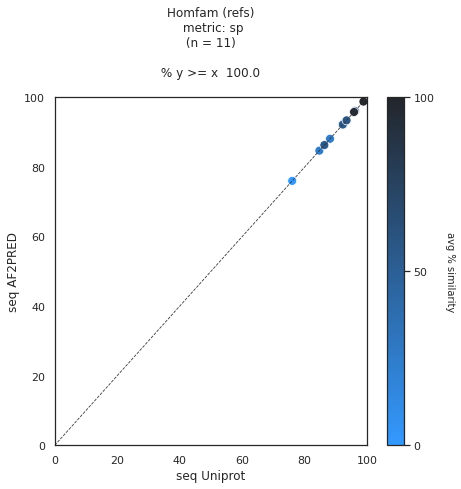

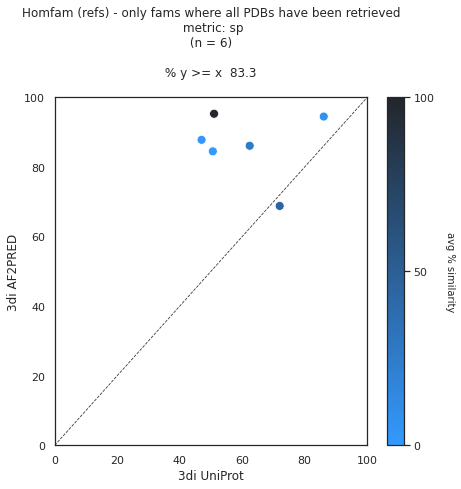

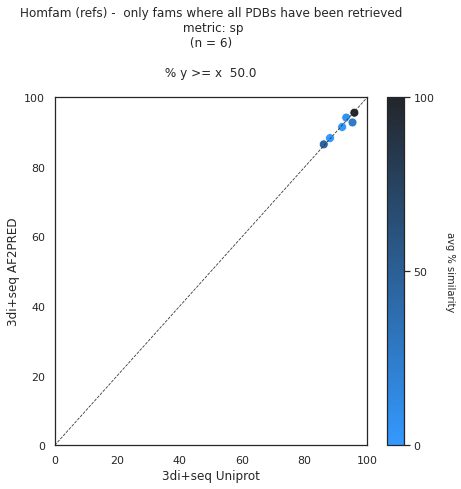

In [10]:
# Compare PDB and AF2 in Homfam
#plot_scatter_perc(proba_scores[proba_scores.db == "PDB"],proba_scores[proba_scores.db == "AF2_PRED"], "seq PDB", "seq AF2PRED",metric = "sp", title = "Homfam (refs)")
#plot_scatter_perc(foldseek_scores[(foldseek_scores.db == "PDB") & (foldseek_scores.family.isin(fams_all_str))],foldseek_scores[foldseek_scores.db == "AF2_PRED"], "3di PDB", "3di AF2PRED",metric = "sp", title = "Homfam (refs) - only fams where all PDBs have been retrieved")
#plot_scatter_perc(foldseek_sequence_scores[(foldseek_sequence_scores.db == "PDB") & (foldseek_sequence_scores.family.isin(fams_all_str))],foldseek_sequence_scores[foldseek_sequence_scores.db == "AF2_PRED"], "3di+seq PDB", "3di+seq AF2PRED",metric = "sp", title = "Homfam (refs) -  only fams where all PDBs have been retrieved")
# TODO -> Compare PDB and AF2 in Benchfam

#plot_scatter_perc(tm_scores[(tm_scores.db == "PDB") & (tm_scores.family.isin(fams_all_str))],tm_scores[tm_scores.db == "AF2_PRED"], "3di PDB", "3di AF2PRED",metric = "tc", title = "Homfam (refs) - only fams where all PDBs have been retrieved")
plot_scatter_perc(proba_scores[proba_scores.db == "UniProtKB"],proba_scores[proba_scores.db == "UniProtKB"], "seq Uniprot", "seq AF2PRED",metric = "sp", title = "Homfam (refs)")
plot_scatter_perc(foldseek_scores[(foldseek_scores.db == "UniProtKB")],foldseek_scores[foldseek_scores.db == "AF2_PRED"], "3di UniProt", "3di AF2PRED",metric = "sp", title = "Homfam (refs) - only fams where all PDBs have been retrieved")
plot_scatter_perc(foldseek_sequence_scores[(foldseek_sequence_scores.db == "UniProtKB")],foldseek_sequence_scores[foldseek_sequence_scores.db == "AF2_PRED"], "3di+seq Uniprot", "3di+seq AF2PRED",metric = "sp", title = "Homfam (refs) -  only fams where all PDBs have been retrieved")


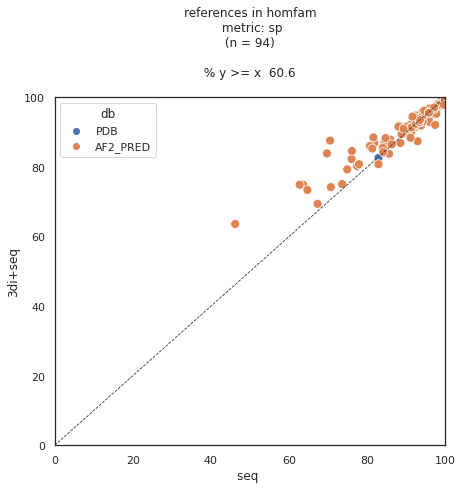

In [123]:
plot_scatter_perc_bin(proba_scores,foldseek_sequence_scores, "seq ", "3di+seq",metric = "sp", title = "references in homfam", hue_var = "db")

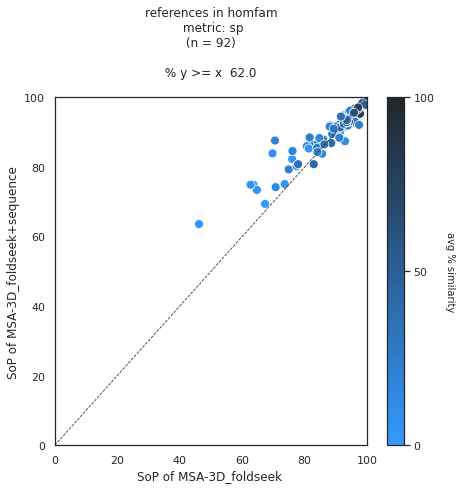

In [18]:
plot_scatter_perc(proba_scores,foldseek_sequence_scores, "SoP of MSA-3D_foldseek ", "SoP of MSA-3D_foldseek+sequence",metric = "sp", title = "references in homfam")


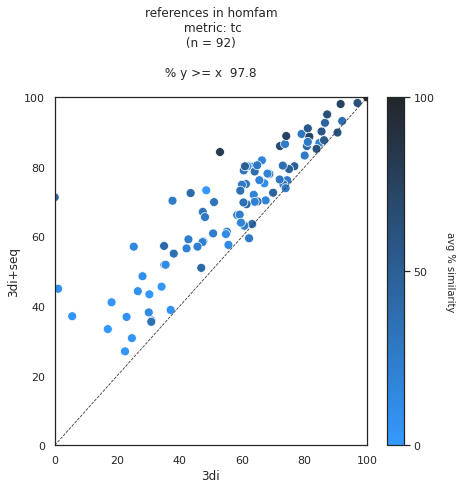

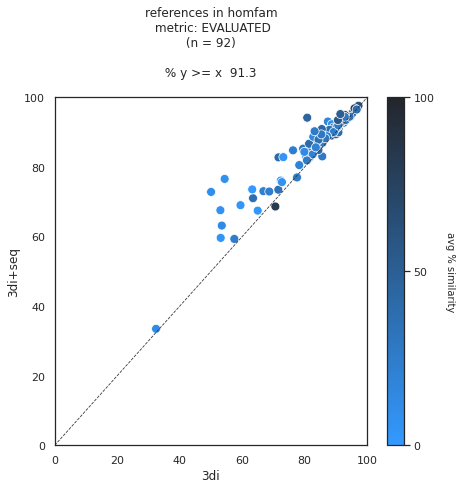

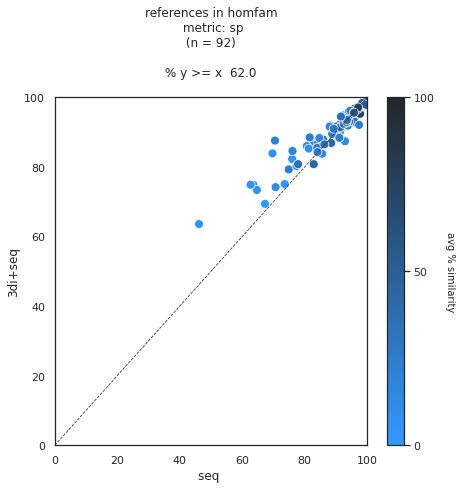

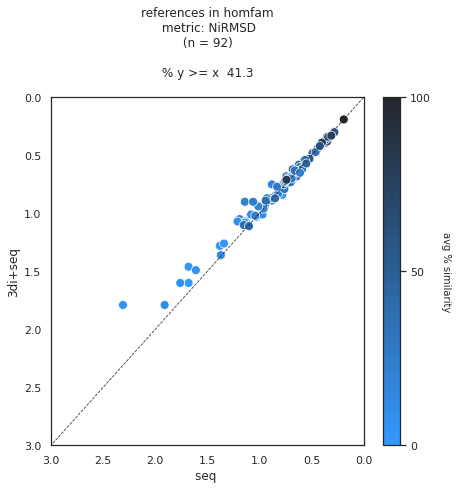

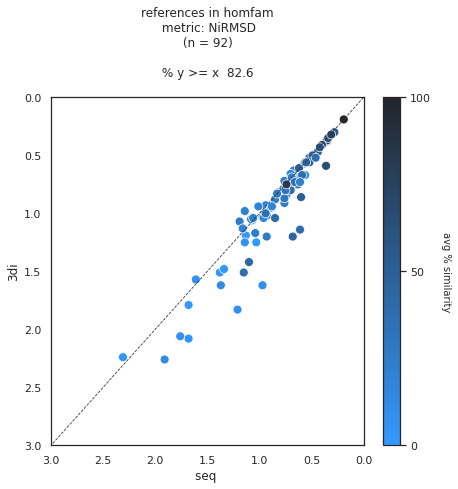

In [19]:
plot_scatter_perc(foldseek_scores,foldseek_sequence_scores, "3di", "3di+seq",metric = "tc", title = "references in homfam")
plot_scatter_perc(foldseek_scores,foldseek_sequence_scores, "3di", "3di+seq",metric = "EVALUATED", title = "references in homfam")
plot_scatter_perc(proba_scores,foldseek_sequence_scores, "seq ", "3di+seq",metric = "sp", title = "references in homfam")
plot_scatter_perc(proba_scores,foldseek_sequence_scores, "seq ", "3di+seq",metric = "NiRMSD", title = "references in homfam")
plot_scatter_perc(proba_scores,foldseek_scores, "seq ", "3di",metric = "NiRMSD", title = "references in homfam")

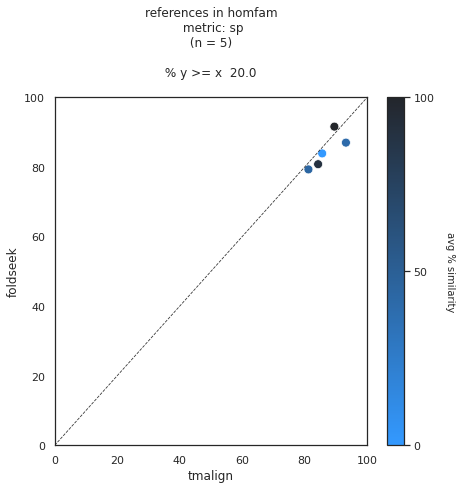

In [104]:
plot_scatter_perc(tm_scores,foldseek_sequence_scores, "tmalign", "foldseek",metric = "sp", title = "references in homfam")

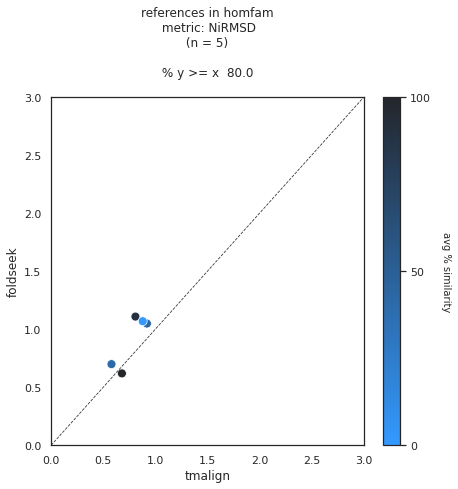

In [105]:
plot_scatter_perc(tm_scores,foldseek_sequence_scores, "tmalign", "foldseek",metric = "NiRMSD", title = "references in homfam")


# Benchfam 

In [14]:
# -------------------------------------------
# Load and save data REAL 
# -------------------------------------------

data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/benchfam_ref/PDB/REAL/"
families = families_benchfam
foldseek_sequence_scores = get_scores_summary("*fs_sequence*", irmsd= True)
proba_scores = get_scores_summary("*proba_only*", irmsd= True)
print("----------------")
foldseek_scores = get_scores_summary("*fs_only*", irmsd= True)
tm_scores = get_scores_summary("*3D*", cat = ["family", "align_method" ,"library_method", "tree_method"], irmsd = True)
benchfam_scores = pd.concat([foldseek_sequence_scores,proba_scores,foldseek_scores,tm_scores])
benchfam_scores.to_csv("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/benchfam_ref/01_PDB_REAL_SCORES_irsmd.csv", index = False)

----------------


In [1]:
# -------------------------------------------
# Load and save data REAL 
# -------------------------------------------

data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/benchfam_ref/PDB/id_1.0_cov_1.0/"
families = families_benchfam
foldseek_sequence_scores = get_scores_summary("*fs_sequence*", irmsd= True)
proba_scores = get_scores_summary("*proba_only*", irmsd= True)
foldseek_scores = get_scores_summary("*fs_only*", irmsd= True)
tm_scores = get_scores_summary("*3D*", cat = ["family", "align_method" ,"library_method", "tree_method"], irmsd = True)
benchfam_scores = pd.concat([foldseek_sequence_scores,proba_scores,foldseek_scores,tm_scores])
#benchfam_scores.to_csv("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/benchfam_ref/01_PDB_1.0_SCORES.csv", index = False)

NameError: name 'families_benchfam' is not defined

In [ ]:
# Once they have been done once, just load the csvs here below (deep cleaning will be needed) 

In [6]:
# LOAD 
benchfam_scores_PDB_REAL = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/benchfam_ref/01_PDB_REAL_SCORES.csv")
benchfam_scores_PDB_1 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/benchfam_ref/01_PDB_1.0_SCORES.csv")
benchfam_scores = pd.concat([benchfam_scores_PDB_REAL,benchfam_scores_PDB_1])

In [7]:
fams_clean_refs = "PF00010,PF00018,PF00051,PF00053,PF00057,PF00062,PF00084,PF00134,PF00178,PF00185,PF00190,PF00191,PF00205,PF00233,PF00249,PF00251,PF00255,PF00258,PF00295,PF00314,PF00334,PF00341,PF00355,PF00405,PF00408,PF00432,PF00462,PF00484,PF00541,PF00620,PF00626,PF00652,PF00653,PF00677,PF00691,PF00722,PF00730,PF00731,PF00881,PF00884,PF00890,PF00961,PF00969,PF01011,PF01023,PF01030,PF01077,PF01152,PF01239,PF01263,PF01488,PF01547,PF01565,PF01568,PF01571,PF01670,PF01842,PF01909,PF02310,PF02321,PF02332,PF02502,PF02558,PF02749,PF02770,PF02776,PF02777,PF02803,PF02807,PF02852,PF02874,PF02881,PF03143,PF04777,PF07687,PF07885,PF08031,PF08544,PF08545,PF12799,PF13412,PF13531,PF13855,PF13857"
fams_clean_refs = fams_clean_refs.split(",")
fams_clean_refs = [x + "-ref" for x in fams_clean_refs]

In [18]:
benchfam_scores

,EVALUATED,APDB,iRMSD,NiRMSD,name,db,sp,tc,column,family,library_method,tree_method,benchmarking_dataset,sim,mean,median,max,n_sequences,domain,align_method
0,77.31,93.18,0.46,0.59,PF14670-ref.fs_sequence.MBED,PDB-REAL,97.1,83.8,86.3,PF14670-ref,fs_sequence,MBED,benchfam,43.07,37.000000,36.5,41,10,multi,NaN
1,86.81,74.28,0.76,0.87,PF02321-ref.fs_sequence.MBED,PDB-REAL,91.8,71.4,74.6,PF02321-ref,fs_sequence,MBED,benchfam,26.29,187.454545,186.0,197,11,multi,NaN
2,78.50,73.10,0.76,0.96,PF02373-ref.fs_sequence.MBED,PDB-REAL,72.2,12.7,14.4,PF02373-ref,fs_sequence,MBED,benchfam,33.54,109.941176,111.0,117,17,mono,NaN
3,80.21,57.33,1.16,1.45,PF00089-ref.fs_sequence.MBED,PDB-REAL,66.8,4.8,4.6,PF00089-ref,fs_sequence,MBED,benchfam,32.78,220.188406,219.0,272,69,mono,NaN
4,82.84,86.17,0.59,0.71,PF16168-ref.fs_sequence.MBED,PDB-REAL,90.1,52.3,60.7,PF16168-ref,fs_sequence,MBED,benchfam,43.96,53.400000,52.5,63,10,multi,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,94.05,81.16,0.63,0.67,PF00415-ref.progressive.3DCOFFEE.MBED,PDB-REAL,97.4,66.1,84.3,PF00415-ref,3DCOFFEE,MBED,benchfam,33.62,50.815789,50.0,66,38,multi,progressive
606,79.29,57.28,1.02,1.29,PF01593-ref.progressive.3DCOFFEE.MBED,PDB-REAL,83.7,30.6,41.1,PF01593-ref,3DCOFFEE,MBED,benchfam,27.41,438.833333,438.0,539,24,mono,progressive
607,77.80,53.89,1.05,1.35,PF01094-ref.progressive.3DCOFFEE.MBED,PDB-REAL,78.0,37.9,36.9,PF01094-ref,3DCOFFEE,MBED,benchfam,28.14,331.166667,343.0,361,12,mono,progressive
608,74.60,78.11,0.69,0.92,PF13508-ref.progressive.3DCOFFEE.MBED,PDB-REAL,95.0,61.2,73.6,PF13508-ref,3DCOFFEE,MBED,benchfam,23.20,84.777778,83.5,92,18,mono,progressive


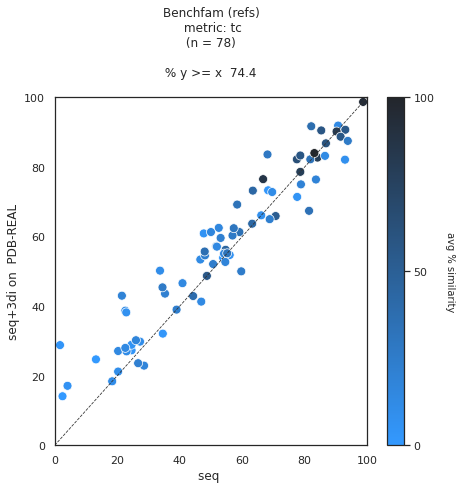

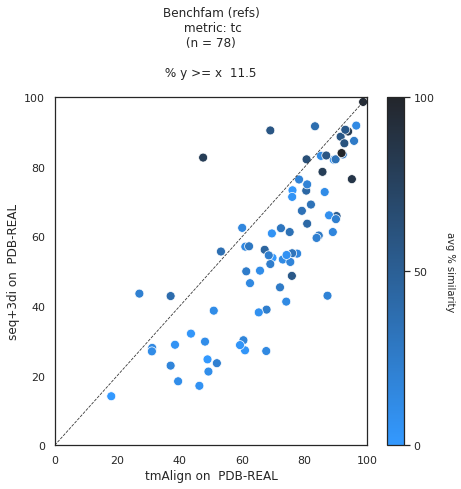

In [22]:
scores = benchfam_scores[benchfam_scores.family.isin(fams_clean_refs)]
met1 = "PDB-REAL"

proba_scores = scores[scores.library_method == "proba_only"]
foldseek_scores = scores[scores.library_method == "fs_only"]
foldseek_sequence_scores = scores[scores.library_method == "fs_sequence"]
tm_scores = scores[scores.library_method == "3DCOFFEE"]
m = "tc"

plot_scatter_perc(proba_scores[proba_scores.db == met1],foldseek_sequence_scores[foldseek_sequence_scores.db == met1], "seq ", "seq+3di on  "+met1,metric = m, title = "Benchfam (refs)")
plot_scatter_perc(tm_scores[tm_scores.db == met1],foldseek_sequence_scores[foldseek_sequence_scores.db == met1], "tmAlign on  "+met1, "seq+3di on  "+met1,metric = m, title = "Benchfam (refs)")


In [9]:
benchfam_scores[benchfam_scores.family == "PF00004-ref"].sort_values("library_method")

,name,sp,tc,column,db,family,library_method,tree_method,benchmarking_dataset,sim,mean,median,max,n_sequences,domain,EVALUATED,APDB,iRMSD,NiRMSD,align_method
1934,PF00004-ref.progressive.3DCOFFEE.MBED,89.9,59.8,70.1,PDB-REAL,PF00004-ref,3DCOFFEE,MBED,benchfam,32.33,129.875,131.0,139,16,mono,78.13,61.62,0.95,1.22,progressive
9,PF00004-ref.progressive.3DCOFFEE.MBED,80.1,21.3,26.9,PDB-id_1.0_cov_1.0,PF00004-ref,3DCOFFEE,MBED,benchfam,32.33,129.875,131.0,139,16,mono,65.12,56.42,1.01,1.56,progressive
1436,PF00004-ref.fs_only.MBED,49.9,5.9,8.6,PDB-REAL,PF00004-ref,fs_only,MBED,benchfam,32.33,129.875,131.0,139,16,mono,NaN,NaN,NaN,NaN,NaN
7,PF00004-ref.fs_only.MBED,18.3,0.6,0.0,PDB-id_1.0_cov_1.0,PF00004-ref,fs_only,MBED,benchfam,32.33,129.875,131.0,139,16,mono,NaN,NaN,NaN,NaN,NaN
287,PF00004-ref.fs_sequence.MBED,68.9,18.3,26.0,PDB-REAL,PF00004-ref,fs_sequence,MBED,benchfam,32.33,129.875,131.0,139,16,mono,NaN,NaN,NaN,NaN,NaN
2,PF00004-ref.fs_sequence.MBED,67.1,20.7,27.6,PDB-id_1.0_cov_1.0,PF00004-ref,fs_sequence,MBED,benchfam,32.33,129.875,131.0,139,16,mono,NaN,NaN,NaN,NaN,NaN
876,PF00004-ref.proba_only.MBED,65.7,21.9,27.0,PDB-REAL,PF00004-ref,proba_only,MBED,benchfam,32.33,129.875,131.0,139,16,mono,NaN,NaN,NaN,NaN,NaN
4,PF00004-ref.proba_only.MBED,65.7,21.9,27.0,PDB-id_1.0_cov_1.0,PF00004-ref,proba_only,MBED,benchfam,32.33,129.875,131.0,139,16,mono,NaN,NaN,NaN,NaN,NaN


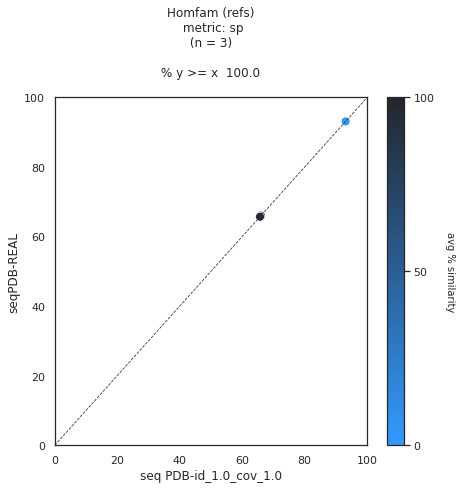

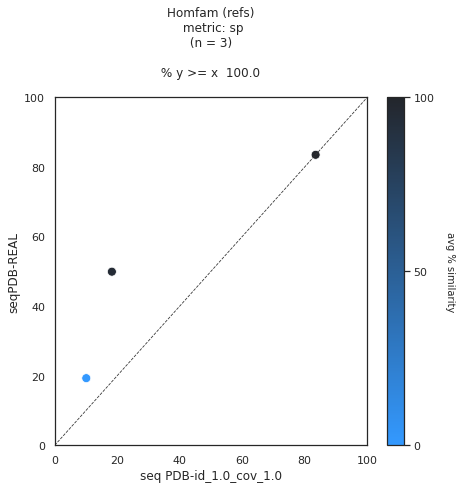

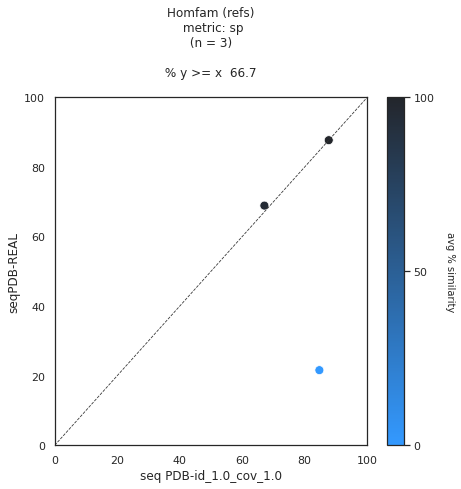

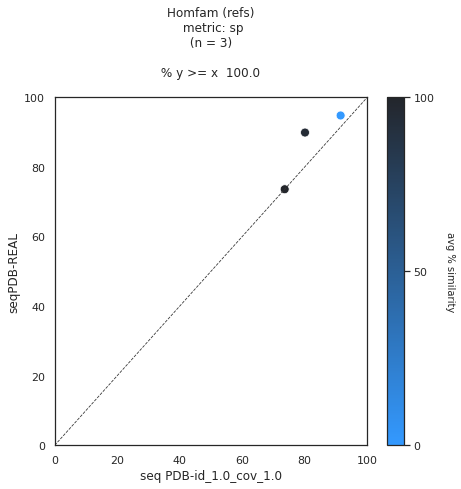

In [5]:
#met1  = "UniProtKB-id_0.9_cov_1.0"
met1 = "PDB-id_1.0_cov_1.0"
met2 = "PDB-REAL"

proba_scores = benchfam_scores[benchfam_scores.library_method == "proba_only"]
foldseek_scores = benchfam_scores[benchfam_scores.library_method == "fs_only"]
foldseek_sequence_scores = benchfam_scores[benchfam_scores.library_method == "fs_sequence"]
tm_scores = benchfam_scores[benchfam_scores.library_method == "3DCOFFEE"]


plot_scatter_perc(proba_scores[proba_scores.db == met1],proba_scores[proba_scores.db == met2], "seq "+met1, "seq"+met2,metric = "sp", title = "Homfam (refs)")
plot_scatter_perc(foldseek_scores[foldseek_scores.db == met1],foldseek_scores[foldseek_scores.db == met2], "seq "+met1, "seq"+met2,metric = "sp", title = "Homfam (refs)")
plot_scatter_perc(foldseek_sequence_scores[foldseek_sequence_scores.db == met1],foldseek_sequence_scores[foldseek_sequence_scores.db == met2], "seq "+met1, "seq"+met2,metric = "sp", title = "Homfam (refs)")
plot_scatter_perc(tm_scores[tm_scores.db == met1],tm_scores[tm_scores.db == met2], "seq "+met1, "seq"+met2,metric = "sp", title = "Homfam (refs)")


In [ ]:
glob.glob("/home/luisasantus/Desktop/crg_cluster/structures_collections/benchfam_ref/mmseqs/UniProtKB/")

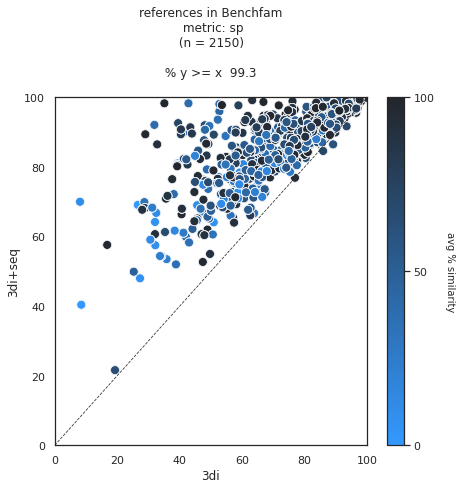

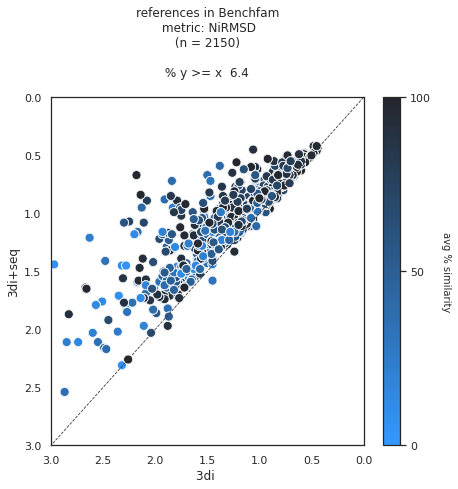

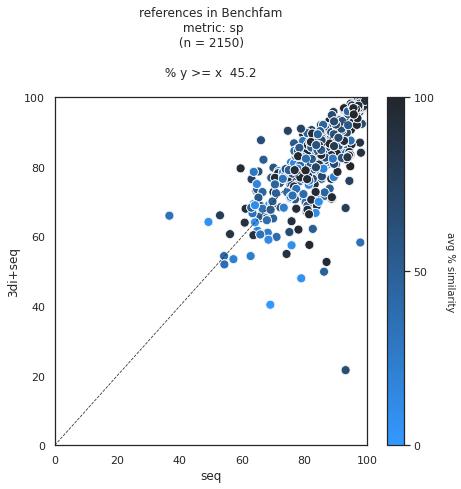

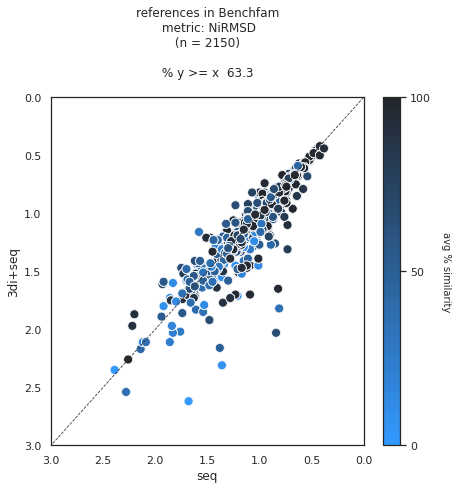

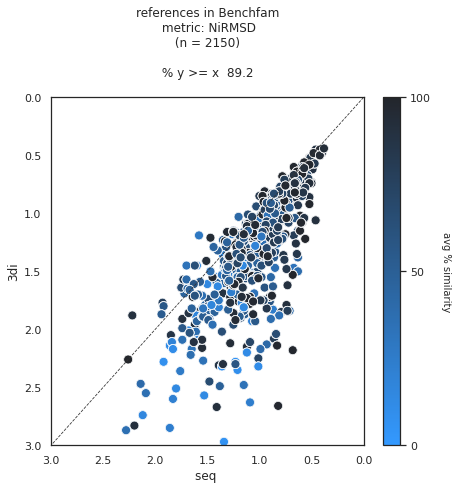

In [154]:
plot_scatter_perc(foldseek_scores,foldseek_sequence_scores, "3di", "3di+seq",metric = "sp", title = "references in Benchfam", hue_var = "tcs")
plot_scatter_perc(foldseek_scores,foldseek_sequence_scores, "3di ", "3di+seq",metric = "NiRMSD", title = "references in Benchfam", hue_var = "tcs")
plot_scatter_perc(proba_scores,foldseek_sequence_scores, "seq", "3di+seq",metric = "sp", title = "references in Benchfam",  hue_var = "tcs")
plot_scatter_perc(proba_scores,foldseek_sequence_scores, "seq", "3di+seq",metric = "NiRMSD", title = "references in Benchfam", hue_var = "tcs")
plot_scatter_perc(proba_scores,foldseek_scores, "seq ", "3di",metric = "NiRMSD", title = "references in Benchfam",  hue_var = "tcs") 

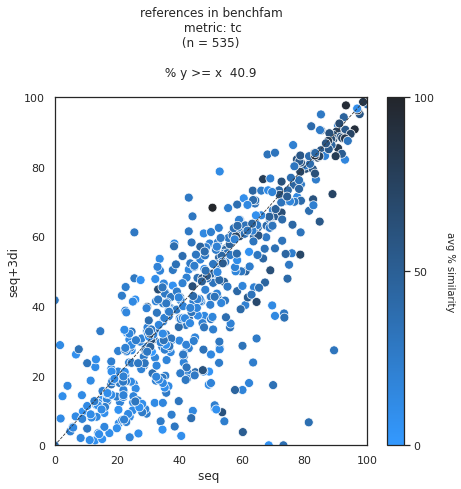

In [55]:
plot_scatter_perc(proba_scores,foldseek_sequence_scores, "seq ", "seq+3di",metric = "tc", title = "references in benchfam")

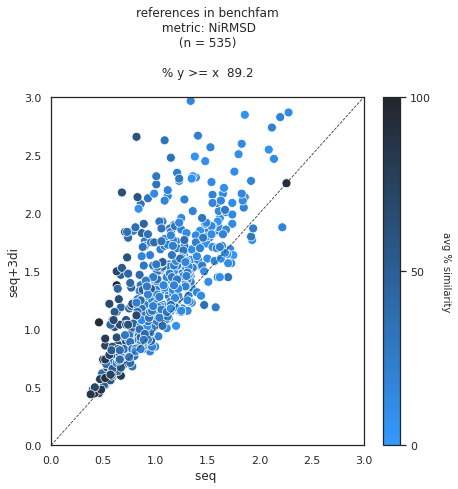

In [74]:
plot_scatter_perc(proba_scores,foldseek_scores, "seq ", "seq+3di",metric = "NiRMSD", title = "references in benchfam")

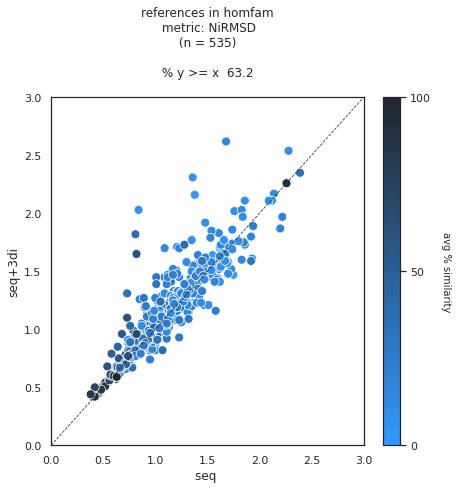

In [14]:
plot_scatter_perc(proba_scores,foldseek_sequence_scores, "seq ", "seq+3di",metric = "NiRMSD", title = "references in homfam")


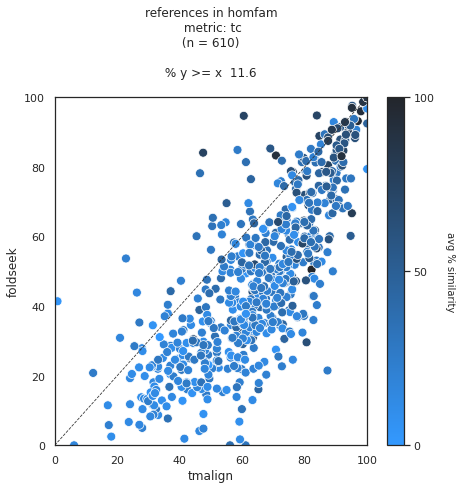

In [56]:
plot_scatter_perc(tm_scores,proba_scores, "tmalign", "foldseek",metric = "tc", title = "references in homfam")

In [62]:
df = proba_scores.merge(tm_scores, on = "family").merge(foldseek_scores, on = "family")

In [67]:
df[(df.sp_x  < df.sp) & (df.sp > df.sp_y)][["family", "sp_x", "sp_y", "sp", "n_sequences"]]

,family,sp_x,sp_y,sp,n_sequences
54,PF11396-ref,66.0,73.6,83.5,10
132,PF01011-ref,88.3,87.0,90.7,14
261,PF00341-ref,94.7,94.3,97.4,10
496,PF02887-ref,84.9,88.2,88.7,13


In [48]:
benchfam_scores[(benchfam_scores.sp >70) & (benchfam_scores.library_method == "fs_sequence") & (benchfam_scores.n_sequences < 15)]

,EVALUATED,APDB,iRMSD,NiRMSD,name,sp,tc,column,family,library_method,tree_method,benchmarking_dataset,sim,mean,median,max,n_sequences,domain,align_method
0,77.31,93.18,0.46,0.59,PF14670-ref.fs_sequence.MBED,97.1,83.8,86.3,PF14670-ref,fs_sequence,MBED,benchfam,43.07,37.000000,36.5,41,10,multi,NaN
1,86.81,74.28,0.76,0.87,PF02321-ref.fs_sequence.MBED,91.8,71.4,74.6,PF02321-ref,fs_sequence,MBED,benchfam,26.29,187.454545,186.0,197,11,multi,NaN
4,82.84,86.17,0.59,0.71,PF16168-ref.fs_sequence.MBED,90.1,52.3,60.7,PF16168-ref,fs_sequence,MBED,benchfam,43.96,53.400000,52.5,63,10,multi,NaN
5,95.58,88.52,0.53,0.56,PF00840-ref.fs_sequence.MBED,97.4,83.1,86.8,PF00840-ref,fs_sequence,MBED,benchfam,52.87,417.363636,426.0,436,11,mono,NaN
7,84.41,77.06,0.74,0.88,PF00890-ref.fs_sequence.MBED,87.7,55.7,67.1,PF00890-ref,fs_sequence,MBED,benchfam,37.59,411.416667,400.5,486,12,mono,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,74.97,75.83,0.67,0.90,PF14833-ref.fs_sequence.MBED,93.5,52.8,54.3,PF14833-ref,fs_sequence,MBED,benchfam,29.85,120.846154,121.0,122,13,mono,NaN
528,72.62,69.47,0.80,1.10,PF00993-ref.fs_sequence.MBED,76.6,9.5,10.2,PF00993-ref,fs_sequence,MBED,benchfam,47.32,80.000000,80.0,81,12,mono,NaN
529,86.74,75.40,0.75,0.87,PF00208-ref.fs_sequence.MBED,92.5,55.0,58.8,PF00208-ref,fs_sequence,MBED,benchfam,39.94,235.307692,234.0,247,13,mono,NaN
531,77.45,68.13,0.92,1.18,PF00211-ref.fs_sequence.MBED,81.0,39.5,40.8,PF00211-ref,fs_sequence,MBED,benchfam,27.89,186.071429,184.5,215,14,multi,NaN


In [68]:
# Investigate some specific cases
# One where it performs not well and one where it performs better 

fam = "PF11396-ref"

In [69]:
benchfam_scores[benchfam_scores.family == fam]

,EVALUATED,APDB,iRMSD,NiRMSD,name,sp,tc,column,family,library_method,tree_method,benchmarking_dataset,sim,mean,median,max,n_sequences,domain,align_method
299,89.13,67.98,0.83,0.93,PF11396-ref.fs_sequence.MBED,87.7,61.2,68.3,PF11396-ref,fs_sequence,MBED,benchfam,32.76,87.3,85.0,95,10,multi,NaN
67,82.61,65.99,1.01,1.23,PF11396-ref.proba_only.MBED,66.0,25.5,28.0,PF11396-ref,proba_only,MBED,benchfam,32.76,87.3,85.0,95,10,multi,NaN
311,88.29,61.41,1.02,1.16,PF11396-ref.fs_only.MBED,83.5,53.1,60.7,PF11396-ref,fs_only,MBED,benchfam,32.76,87.3,85.0,95,10,multi,NaN
367,83.45,67.81,0.83,1.00,PF11396-ref.progressive.3DCOFFEE.MBED,73.6,42.9,40.3,PF11396-ref,3DCOFFEE,MBED,benchfam,32.76,87.3,85.0,95,10,multi,progressive


In [70]:
# Load libraries 

library_seq = glob.glob("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/benchfam_ref/alignments/"+fam+"/*fsproba*/*.lib")[0]
library_fs = glob.glob("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/benchfam_ref/alignments/"+fam+"/*fsonly*/*.lib")[0]
library_tmalign = glob.glob("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/benchfam_ref/alignments/"+fam+"/*probaonly*/*.lib")[0]
library_seq_fs = glob.glob("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/benchfam_ref/alignments/"+fam+"/*3D*/*.lib")[0]

# Sequence 
residues_seq = get_summary_lib(library_seq)
residues_seq["library"] = "sequence"
# Structure fs
residues_foldseek = get_summary_lib(library_fs)
residues_foldseek["library"] = "foldseek"

[Text(0.5, 0, 'residue of seq1')]

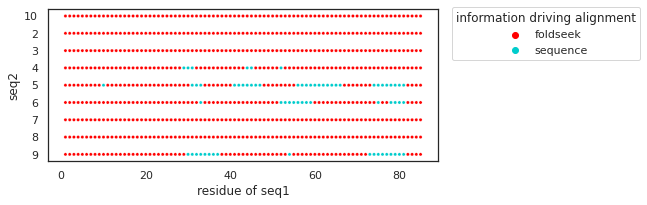

In [71]:
import warnings
warnings.filterwarnings('ignore')

size_fig = 0.7
f, ax = plt.subplots(figsize=(10*size_fig,4*size_fig ))

seq1 = "1"
#seq2 = "6"

#seqs  = ["1","2", "3", "4", "5", "6"]
seqs  = ["2"]

#residues= residues_foldseek
#residues= pd.concat([residues_tmalign, residues_tmalign_seq,residues_seq ])
residues= pd.concat([residues_foldseek,residues_seq ])

residues.seq2 = residues.seq2.replace(r'\n','', regex=True).str.strip() 

#df = residues[(residues.seq1 == sequence) & (residues.seq2.isin(seqs))]
df = residues[(residues.seq1 == seq1)]

df.value = df.value.astype(int)
df.res1 = df.res1.astype(int)
df.res2 = df.res2.astype(int)
#df = df[df.res1 < 50 ]
df.value = df.value.astype(int)
df.value = df.value/10
df.value = df.value.astype(int).astype(float)
df["s"] = 150
df.loc[df.library=="foldseek", 's'] = 150
df.loc[df.library=="sequence", 's'] = 50

df = df.reset_index()
df['value_transformed'] = df.groupby("id")['value'].transform('max')

# group the data by 'group' and find the index of the max value for each group
idx = df.groupby(['res1', "seq2"])['value_transformed'].idxmax()
# use the index to select the columns with the max values for each group
df = df.loc[idx,:]

s = df.s
ax = sns.scatterplot(data = df, x = "res1", y = "seq2", s = 10, hue = "library", palette = ["red", "#00CCCC"]) 
ax.legend(bbox_to_anchor=(1.02, 1.05), title = "information driving alignment")
ax.set(xlabel = "residue of seq1")